# 02477 Bayesian Machine Learning - Exercise 13

In [30]:
import jax.numpy as jnp
import matplotlib.pylab as plt
import seaborn as snb
from jax import random
from jax import jit
from jax.scipy.special import logsumexp
from jax import grad
from jax import hessian
from jax.flatten_util import ravel_pytree

from nn import NeuralNetwork
from nn import plot_predictions

# style stuff
snb.set_style('darkgrid')
snb.set_theme(font_scale=1.5)

### Overview

In this exercise we will study Bayesian-inspired methods for deep learning. The exercise is divided into the following parts:

**Content**

- Part 1: Introduction and theory
- Part 2: Fitting a neural network to a toy problem with MAP-inference
- Part 3: Last layer Laplace approximations (LLLA)
- Part 4: Deep ensembles
- Part 5: Modelling the Concrete dataset from the UCI repository



**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.

**Note**: If you find yourself spending more than 30minutes on a single task, consider asking for help or look up at the solution for inspiration and move forward.

**Note**: This notebook will also make use of the package `optax` for optimization.

---



## Part 1:  Introduction and theory

In this exercise, we will explore Bayesian-inspired methods for deep learning. The core concept in Bayesian methods is to compute weighted averages wrt. the posterior distribution of the parameters instead of "betting everything" on a single set of parameters, i.e. **a point estimate**. We will focus on supervised learning with probabilistic models of the form

\begin{align*}
p(\mathbf{y}, \mathbf{w}) = \prod_{n=1}^N p(y_n|\mathbf{w})p(\mathbf{w}) \tag{1},
\end{align*}

where $p(y_n|\mathbf{w})$ is the likelihood for the $n$-th observation, which is parametrized by a neural network with parameters $\mathbf{w}$. Ideally, we would like to compute the posterior distribution $p(\mathbf{w}|\mathbf{y})$ and use this to compute the posterior predictive distribution, but this is generally a very difficult task for neural network models due to the high-dimensional nature of the models, the complexity posterior geometry, and scale of modern datasets. 



**Non-linear regression models with heteroscedastic noise**

In this exercise, we will study non-linear regression models with Gaussian likelihoods of the form

\begin{align*}
    p(y_n|\mathbf{w}, \mathbf{x}_n) = \mathcal{N}(y_n|\mu_{\mathbf{w}}(\mathbf{x}_n), \sigma^2_{\mathbf{w}}(\mathbf{x}_n)). \tag{2}
\end{align*}

In this model, we assume **heteroscedasticity**, i.e. we allow the noise variance of the observations to depend on the input $\mathbf{x}$. This should be contrasted with **homoscedastic models**, where the noise variance is assumed to be constant, i.e. $\sigma^2(\mathbf{x}_n) = \sigma^2_0$. Note that this is the **variance of the likelihood**, i.e. the aleatoric component of the uncertainty, so this should not be confused with epistemic uncertainty, which can also depend on $x$.

We will parameterize this likelihood using a neural network with two outputs, where the first output represents the mean function of the Gaussian distribution and the second represent the log variance of the Gaussian distribution. That is, if $f(\mathbf{x}|\mathbf{w}): \mathbb{R}^D \rightarrow \mathbb{R}^2$ is a neural network with parameters $\mathbf{w}$ and two output nodes, then

\begin{align*}
\mu_{\mathbf{w}}(\mathbf{x}) &= f_{1}(\mathbf{x}|\mathbf{w}) \tag{3}\\
\log \sigma^2_{\mathbf{w}}(\mathbf{x}) &= f_{2}(\mathbf{x}|\mathbf{w}).
\end{align*}

This construction implies that $\sigma^2_{\textbf{w}}(\mathbf{x}) = e^{f_{2}(\mathbf{x}|\mathbf{w})} > 0$, which ensures that the predicted noise variance will always be strictly positive no matter what the neural network outputs.


We will use a fully-connected neural network with two hidden layers:

\begin{align*}
\mathbf{z}_1 &= h(\mathbf{W}_0\mathbf{x} + \mathbf{b}_0),\\
\mathbf{z}_2 &= h(\mathbf{W}_1\mathbf{z}_1 + \mathbf{b}_1),\\
\mathbf{f} &= \mathbf{W}_2\mathbf{z}_2 + \mathbf{b}_2, \tag{4}
\end{align*}


where $\mathbf{f}\in \mathbb{R}^2$ and $\mathbf{W}_0$ and $\mathbf{b}_0$ are the weights and biases for the first layer etc and $h$ is a non-linear activation function, which we will take to be the tangent hyperbolic function. We assume an isotropic Gaussian prior on all parameters, i.e. if $\mathbf{w} = \left\lbrace \mathbf{W}_0, \mathbf{b}_0, \mathbf{W}_1, \mathbf{b}_1, \mathbf{W}_2, \mathbf{b}_2  \right\rbrace$ denotes all the parameters of the network, then

\begin{align*}
p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{0}, \alpha^{-1}\mathbf{I}) \tag{5}
\end{align*}
for $\alpha > 0$.



**Approximate inference**


In Bayesian deep learning, we aim to find a tractable approximation $q(\mathbf{w})$ such that we can approximate the posterior predictive distribution for a new point $y^*$ as follows

\begin{align*}
p(y^*|\mathbf{y}, \mathbf{x}^*) \approx \int p(y^*|\mathbf{w}, \mathbf{x}^*) q(\mathbf{w}) \text{d}\mathbf{w} \tag{6}.
\end{align*}

For example, for Laplace approximations and Gaussian variational approximations, we have $q(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{V})$ and the integral in eq. (6) can be approximated using Monte Carlo sampling 

\begin{align*}
p(y^*|\mathbf{y}, \mathbf{x}^*) \approx \frac{1}{S} \sum_{i=1}^S p(y^*|\mathbf{w}^{(i)}, \mathbf{x}^*), \quad\quad\text{where}\quad\quad \mathbf{w}^{(i)} \sim  q(\mathbf{w}) \tag{7}.
\end{align*}




**Deep Ensembles**

An alternative to Gaussian posterior approximations is **Deep Ensembles** (DE), where we simply fit our model $S$-times from different initial parameters (e.g. by using different seeds) and treat the resulting parameters vectors $\mathbf{w}^{(i)}$ for $i = 1, \dots, S$ as pseudo-Monte Carlo samples corresponding to a posterior approximation of the form $q_{\text{DE}}(\mathbf{w}) = \frac{1}{S}\sum_{i=1}^S \delta(\mathbf{w}-\mathbf{w}^{(i)})$,
where $\delta(\cdot)$ is Dirac's delta function. Thus, for deep ensembles, we approximate the posterior predictive distribution as follows
\begin{align*}
p(y^*|\mathbf{y}, \mathbf{x}^*) \approx \int p(y^*|\mathbf{w}, \mathbf{x}^*) q_{\text{DE}}(\mathbf{w}) \text{d}\mathbf{w} = \frac{1}{S}\sum_{i=1}^S  p(y^*|\mathbf{w}^{(i)}, \mathbf{x}^*). \tag{8}
\end{align*}

MAP-inference is equivalent to a "degenerate" deep ensemble with $S = 1$ and therefore, we can think of MAP-inference as approximate posterior inference with the degenerate approximation $q_{\text{MAP}}(\mathbf{w}) = \delta(\mathbf{w}- \mathbf{w}_{\text{MAP}})$:

\begin{align*}
p(y^*|\mathbf{y}, \mathbf{x}^*) \approx \int p(y^*|\mathbf{w}, \mathbf{x}^*) q_{\text{MAP}}(\mathbf{w}) \text{d}\mathbf{w} = p(y^*|\mathbf{w}_{\text{MAP}}, \mathbf{x}^*), \tag{8b}
\end{align*}

which we also know as a **plugin approximation**.

**Task 1.1**: Suppose you have trained a deep ensemble with $S = 10$ models and let $\mathbf{f}^{(i)} \in \mathbb{R}^2$ denote the output of the neural network for the $i$'th model for a given input $\mathbf{x}^*$. Determine the expression for the resulting approximate posterior predictive distribution.



$$
p(y^*|\mathbf{y}, \mathbf{x}^*) = \frac{1}{S} \sum_{i=1}^S \mathcal{N} \left(y^* | f_1(\mathbf{x}^* | \mathbf{w}_i), \exp ( f_2(\mathbf{x}^* | \mathbf{w}_i)) \right)
$$

***Last-layer Laplace approximations***

In this exercise, we will compare standard **MAP-inference** with **deep ensembles** and **Last Layer Laplace Approximations** (LLLA). To construct a Laplace approximation, we need to evaluate to Hessian of the log joint distribution, which can be prohibitively expensive for even moderately sized networks. The LLLA approximation is a cheap alternative, where we treat all layers as deterministic except for the very last layer. That is, for our network with 2 hidden layers, we treat the parameters $\mathbf{W}_0, \mathbf{b}_0, \mathbf{W}_1,$ and $\mathbf{b}_1$ as deterministic and only apply the Laplace approximation for the parameters of the last layer, i.e. $\mathbf{W}_2$ and $\mathbf{b}_2$. Consequently, we only need to estimate a much smaller Hessian matrix. Furthermore, LLLA approximation has the additional benefits that it can easily be added *post-hoc* to a pretrained model.

Let $L$ be the number of layers and let $\mathbf{z}_2 \in \mathbb{R}^H$, then we can separate the network into two functions: A function $f_{1:L-1}$ that maps from the input to output of the second hidden layer, i.e.  $\mathbf{z}_2 = f_{1:L-1}(\mathbf{x}): \mathbb{R}^D \rightarrow \mathbf{R}^H$, and a function $f_{L}$ that maps $\mathbf{z}_2$ to the output of the network, i.e. $f_L: \mathbb{R}^H \rightarrow \mathbb{R}^O$ defined by

\begin{align*}
f_L(\mathbf{z}_2|\mathbf{w}_L) &= \mathbf{W}_2\mathbf{z}_2 + \mathbf{b}_2,
\end{align*}

where $\mathbf{w}_L = \left\lbrace \mathbf{W}_2, \mathbf{b}_2 \right\rbrace$ is the parameters of the layer layer and $\mathbf{w}_{1:L-1}$ is the parameters of the rest of the network. That is, to apply LLLA, we first compute the MAP estimate of the full network, i.e. $\mathbf{w}_{\text{MAP}}$, but we only have to compute the Hessian wrt. $\mathbf{w}_L$.


**Evaluation**

A common way to evaluate probabilistic models is using the average *log predictive density* (LPD) for a dataset (arguments for this metric can be found in [Evaluating Predictive Uncertainty Challenge](https://www.quinonero.net/Publications/quinonero06epuc.pdf), Quiñonero-Candela et al., 2006). For a set of posteriors samples $\left\lbrace \mathbf{w}^{(i)} \right\rbrace_{i=1}^S$ (no matter whether they come from a Laplace approximation or deep ensembles etc), we can compute the posterior distribution of $y$ by computing the output of the network for each of the weight samples $\mathbf{w}^{(i)}$ to get

\begin{align*}
\left\lbrace f^{(i)}(\mathbf{x}^*) \right\rbrace_{i=1}^S \tag{9}
\end{align*}

 for a test point $\mathbf{x}^*$. Finally, we can use these samples to measure the log predictive density as follows

\begin{align*}
\text{LPD}(y^*) = \log p(y^*|\mathbf{y}, \mathbf{x}^*) \approx \log \left[ \frac{1}{S}\sum_{i=1}^S  p(y^*|\mathbf{w}^{(i)}, \mathbf{x}^*) \right].
\end{align*} 

For our specific model, which outputs the mean and log variance of the Gaussian predictive distribution, the log predictive density for $y^*$ becomes

\begin{align*}\text{LPD}(y^*) = \log \left[\frac{1}{S}\sum_{i=1}^S \mathcal{N}(y^*|f_1^{(i)}(\mathbf{x}^*), e^{f_2^{(i)}(\mathbf{x}^*)})\right].\tag{10}
\end{align*} 

Hence, for a test of $M$ observations, the averaged LPD becomes
\begin{align*}
\text{LPD} = \frac{1}{M}\sum_{m=1}^M \log \left[\frac{1}{S}\sum_{i=1}^S \mathcal{N}(y^*_m|f_1^{(i)}(\mathbf{x}^*_m), e^{f_2^{(i)}(\mathbf{x}^*_m)})\right].\tag{11}
\end{align*} 

**Note**: To avoid numeric underflow, the logarithm of the inner sum is often evaluated using the `logsumexp` 'trick'.

## Part 2:  Fitting a neural network to a toy problem with MAP-inference

Let's load a small toy dataset:

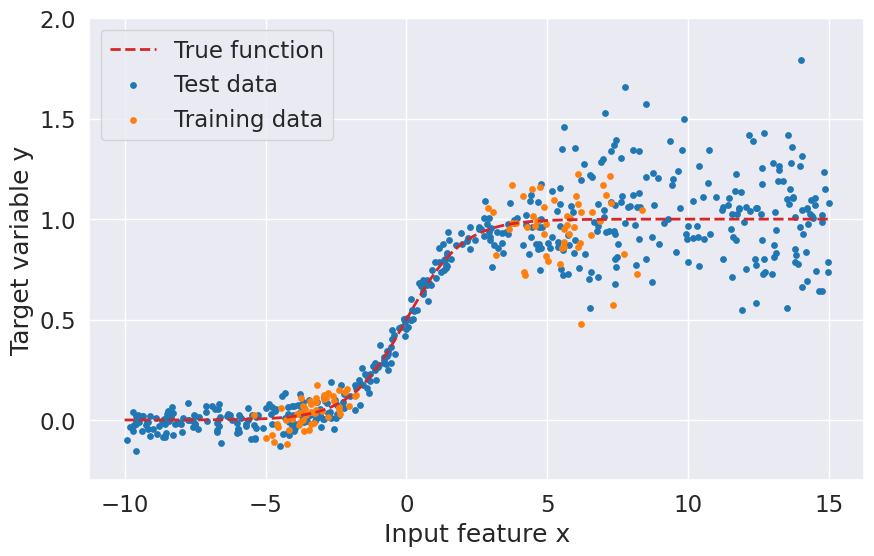

In [31]:
# load data
data = jnp.load('./ex13_toydata.npz')
X_train = jnp.array(data['X_train'])
X_test = jnp.array(data['X_test'])
Xp = jnp.array(data['Xp'])
y_train = jnp.array(data['t_train'])
y_test = jnp.array(data['t_test'])

# the data is generating using a sigmoid as underlying signal
sigmoid = lambda x: 1/(1+jnp.exp(-x))
f = lambda x: sigmoid(x)

# helper function for plotting
def plot_data(ax):
    ax.plot(Xp, f(Xp), color=plt.cm.tab20(6), ls="--", linewidth=2, label='True function')
    ax.scatter(X_test, y_test, s=15, color=plt.cm.tab20(0), label='Test data')
    ax.scatter(X_train, y_train, s=15, color=plt.cm.tab20(2), label='Training data')
    ax.set(xlabel='Input feature x', ylabel='Target variable y', ylim=(-0.3, 2))
    
# plot data
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_data(ax)
ax.legend()

**Task 2.1**: Consider the dataset above. Why would the assumption of **homoscedastic noise** be inappropriate here? [**Discussion question**]

It seems that there is a lot more uncertainty in the data after $ x = 2 $, so the variance is dependent on $ x $

**Task 2.2**: Complete the implementation of the log likelihood function below.

In [32]:
def log_npdf(x, m, v):
    return -0.5*(x-m)**2/v - 0.5*jnp.log(2*jnp.pi*v)

def log_lik_regression(f, y):
    """ implement the log likelihood in eq. (2)  for network outputs f and observations y
    
    inputs:
    f           --  output of neural network (jnp.array: N x 2)
    y           --  targets/observations     (jnp.array: N x 1)

    output:
    log_lik     --  sum of log likelihoods terms for observations in y (jnp.float64: scalar)

    """
    v = jnp.exp(f[:,1])
    mu = f[:,0]
    log_lik = jnp.sum(log_npdf(x = y, m = mu[:,None], v = v[:,None]))

    return log_lik


# simple sanity checks for your implementation
assert log_lik_regression(jnp.ones((len(y_train), 2)), y_train).ndim == 0, f"The output of log_lik_regression must be a scalar (float), but the output shape was {log_lik_regression(jnp.ones((len(y_train), 2)), y_train).shape}. Please verify that your implementation is correct."
assert jnp.allclose(log_lik_regression(jnp.ones((len(y_train), 2)), y_train), -150.62110358638134), f"The output of log_lik_regression must be  close to -150.62110358638134, but the output was {log_lik_regression(jnp.ones((len(y_train), 2)), y_train)}. Please verify that your implementation is correct."

The following cell will compute the MAP-solution of the neural network by optimizing the log joint distibution wrt. $\mathbf{w}$:

In [33]:
# specify architecture and prior
num_inputs = 1
hidden1 = 20
hidden2 = 20
num_outputs = 2
network_shape = [num_inputs, hidden1, hidden2, num_outputs]
alpha = 0.5

# create and train network
model_MAP = NeuralNetwork(X_train, y_train, network_shape, log_lik_regression, alpha=alpha, step_size=1e-2, batch_size=None, num_iters=2000, seed=0)

Itt = 100/2000 (5.0%), log joint = -634.79
Itt = 200/2000 (10.0%), log joint = -611.75
Itt = 300/2000 (15.0%), log joint = -608.30
Itt = 400/2000 (20.0%), log joint = -583.54
Itt = 500/2000 (25.0%), log joint = -554.56
Itt = 600/2000 (30.0%), log joint = -553.56
Itt = 700/2000 (35.0%), log joint = -554.88
Itt = 800/2000 (40.0%), log joint = -553.31
Itt = 900/2000 (45.0%), log joint = -554.31
Itt = 1000/2000 (50.0%), log joint = -551.84
Itt = 1100/2000 (55.0%), log joint = -550.81
Itt = 1200/2000 (60.0%), log joint = -567.57
Itt = 1300/2000 (65.0%), log joint = -553.14
Itt = 1400/2000 (70.0%), log joint = -550.45
Itt = 1500/2000 (75.0%), log joint = -549.57
Itt = 1600/2000 (80.0%), log joint = -549.73
Itt = 1700/2000 (85.0%), log joint = -556.82
Itt = 1800/2000 (90.0%), log joint = -560.15
Itt = 1900/2000 (95.0%), log joint = -548.07
Itt = 2000/2000 (100.0%), log joint = -547.71


We can now use the function `model_MAP.predict` to compute a forward pass through the network. That is, it evaluates $f(\mathbf{x})$ for the input points in the array `Xp` using $\mathbf{w}_{\text{MAP}}$:


In [34]:
pred = model_MAP.predict(Xp)
print(f'shape of Xp: {Xp.shape}')
print(f'shape of pred: {pred.shape}')

shape of Xp: (100, 1)
shape of pred: (100, 2)


The output variable `pred` is an $N \times 2$ array because the network has two outputs. 

For the MAP-method, we can easily compute the predictive mean and resulting intervals:

- For each input point $\mathbf{x}$, we predict a mean value $\mu(\mathbf{x})$ and a variance $\sigma^2(\mathbf{x})$ of a Gaussian.

- A $95%$-interval for a Gaussian $\mathcal{N}(x|m, v)$ is approximately $\left[m - 1.96\sqrt{v}, m + 1.96\sqrt{v}\right]$.


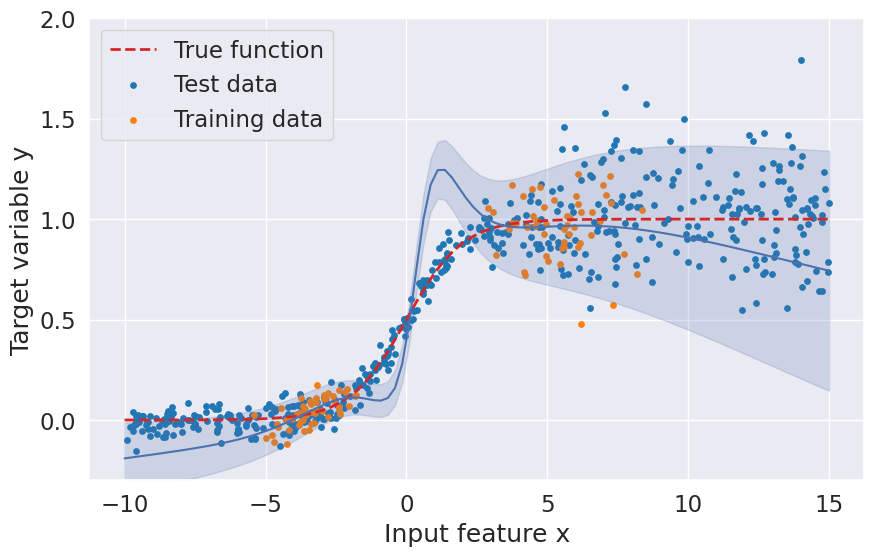

In [35]:
def extract_mean_and_var(pred, samples=False):
    if samples:
        # if samples == True, pred is expected to be of shape [num_samples, P, 2], where P is the number of input vectors
        return pred[:, :, 0], jnp.exp(pred[:, :, 1])
    else:
        # if samples == False, pred is expected to be of shape [P, 2], where P is the number of input vectors

        return pred[:, 0], jnp.exp(pred[:, 1])


# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_data(ax)

# separate mean and variance 
mu_MAP, v_MAP = extract_mean_and_var(pred)

# plot
lower_MAP, upper_MAP = mu_MAP - 1.96*jnp.sqrt(v_MAP), mu_MAP + 1.96*jnp.sqrt(v_MAP)
ax.plot(Xp, mu_MAP)
ax.fill_between(Xp.ravel(), lower_MAP, upper_MAP, color='b', alpha=0.2)
ax.legend()

**Task 2.3**: How can you tell from the resulting fit that we have used a heteroscedastic model? Comment on the quality of the fit. Is it reasonable? [**Discussion question**]

It doesn't seem that reasonable, especially the large bump. It does seem to take into account the increasing variance as X increases

Next, let's compute the average LPD for both the training and test set.

**Task 2.4**: Compute the average LPD for the training and the test sets.

*Hints*:
- Recall that $q_{\text{MAP}}(\mathbf{w}) = \delta(\mathbf{w}- \mathbf{w}_{\text{MAP}})$ and use eq. (8b) and (11).


In [36]:
def compute_lpd(x, y, model):
    f = model.predict(x)
    mu, v = extract_mean_and_var(f)
    # log = model.log_lik_fun(f = f, y = y)
    log = log_npdf(x = y, m = mu[:,None], v = v[:,None])
    return jnp.mean(log)

print(compute_lpd(x = X_train, y = y_train, model= model_MAP))
print(compute_lpd(x = X_test, y = y_test, model = model_MAP))

1.0351777
-1.2176338


## Part 3:  Last layer Laplace approximations (LLLA)

Next, we will study the last-layer Laplace approximation. The model class `NeuralNetwork` has two convenient functions for this purpose: `first_layers(params, X)` and `last_layer(param_last_layer, z)`, which implements $f_{1:L-1}$ and $f_L$, respectively. 

The cell below provides a simple implementation of LLLA. A couple of details of about the implementation:

 - The `model.params` variable stores all parameters of the network as a nested list: [[$\mathbf{W}_0, \mathbf{b}_0$], [$\mathbf{W}_1, \mathbf{b}_1$], [$\mathbf{W}_2, \mathbf{b}_2$]].
 - The function `ravel_pytree` takes a nested list of parameters as input and returns 1) a flattened version of the list (i.e. a vector), and 2) an `unflatten` function to the reverse this operation.
 - We will use the flattened parameter vector for computing the Hessian using JaX.


In [37]:
def compute_LLLA(model):
    """ compute last-layer Laplace approximation based on a pretrained model object with L layers """

    # get full list of parameters for network and extract parameters of last layer
    full_params = model.params
    last_params = full_params[-1]

    # flatten parameters of the last layer to prepare for the approximation
    w_last_flat, unflatten = ravel_pytree(last_params)

    # compute activation after first L-1 layers using input features and parameters
    z = model.first_layers(full_params, model.X)

    # prepare for Hessian computation by constructing function for evaluating the last layer of the neural network
    def last_layer_obj(w_):
        p = unflatten(w_)                       # unflatten
        y = model.last_layer(p, z)              # map through last layer
        return -model.log_lik_fun(y, model.y)

    # compute Hessian of log likelihood
    H_loglik = hessian(last_layer_obj)(w_last_flat)

    # comptue Hessian of log prior
    H_logprior = model.alpha * jnp.identity(len(w_last_flat))

    # compute Hessian of log joint
    H = H_loglik + H_logprior
    
    # can be done more efficiently depending on the Hessian approximation, but will be less transparent.
    S = jnp.linalg.inv(H)

    # return params of last layer (flattened), estimated covariance matrix, the estimated hessian and a function for unflatting the parameters
    return w_last_flat, S, H, unflatten


w_MAP_flat, S_LLLA, H, unflatten = compute_LLLA(model_MAP)


Thus, the array `w_MAP_flat` and  the matrix `S_LLLA` contain the mean and covariance matrix of the posterior approximation of the last-layer, respectively.

**Task 3.1**: Fill in the missing pieces in the implementation below:

In [38]:
def predict_LLLA(key, X, model, w_LLLA_flat, S_LLLA, num_samples=1000):
    """ Computes the samples from the LLLA predictive distribution using a pretrained model object 
        and an LLLA approximation specificied by a mean vector w_LLLA_flat and a covariance matrix S_LLLA.
        B denotes the number of parameters in the last layer

    inputs:
    key          ---    key for JaX random number generator
    X            ---    input points (jnp.array: P x D)
    model        ---    NeuralNetwork object (pretrained) 
    w_LLLA_flat  ---    vector of mean parameters for the last layer (jnp.array: B x 1)
    S_LLLA_flat  ---    covarince matrix for the parameters of the last laeyr (jnp.array: (B x B))
    num_samples  ---    number of samples to generate for each input

    outputs:
    preds_LLLA   ---    samples from the predictive distribution for each input in X (jnp.array: num_samples x P x 2)
    """

    # first feed the inputs through the first part of network
    # print(len(first_layers))
    z = model.first_layers(model.params, X)

    # then we will sample from the approximate posterior of the last layer
    w_samples = random.multivariate_normal(key = key, mean = w_LLLA_flat, cov = S_LLLA, shape = (num_samples,))

    # compute predictions for each posterior sample
    preds_LLLA = jnp.stack([model.last_layer(unflatten(w_i), z) for w_i in w_samples]) 

    
    return preds_LLLA


# make predictions for plotting
key = random.PRNGKey(1)
preds_LLLA_pred = predict_LLLA(key, Xp, model_MAP, w_MAP_flat, S_LLLA)

# sanity check
assert(preds_LLLA_pred.shape == (1000, 100, 2)), f"The shape of preds_LLLA_pred must be (1000, 100, 2), but was found to be {preds_LLLA_pred.shape}. Go back and check your implementation."

# split into mean and variance
mu_LLLA_pred, v_LLLA_pred = extract_mean_and_var(preds_LLLA_pred, samples=True)
print(f'shape of mu_LLLA_pred: {mu_LLLA_pred.shape}')
print(f'shape of  v_LLLA_pred: {v_LLLA_pred.shape}')

shape of mu_LLLA_pred: (1000, 100)
shape of  v_LLLA_pred: (1000, 100)


The two arrays above now contains $S= 1000$ samples of the mean and variance of the Gaussian distribution for each of the 100 points in the array `Xp`. We can use those for plotting the predictive distribution.


Let's compare the predictions for MAP and LLLA:

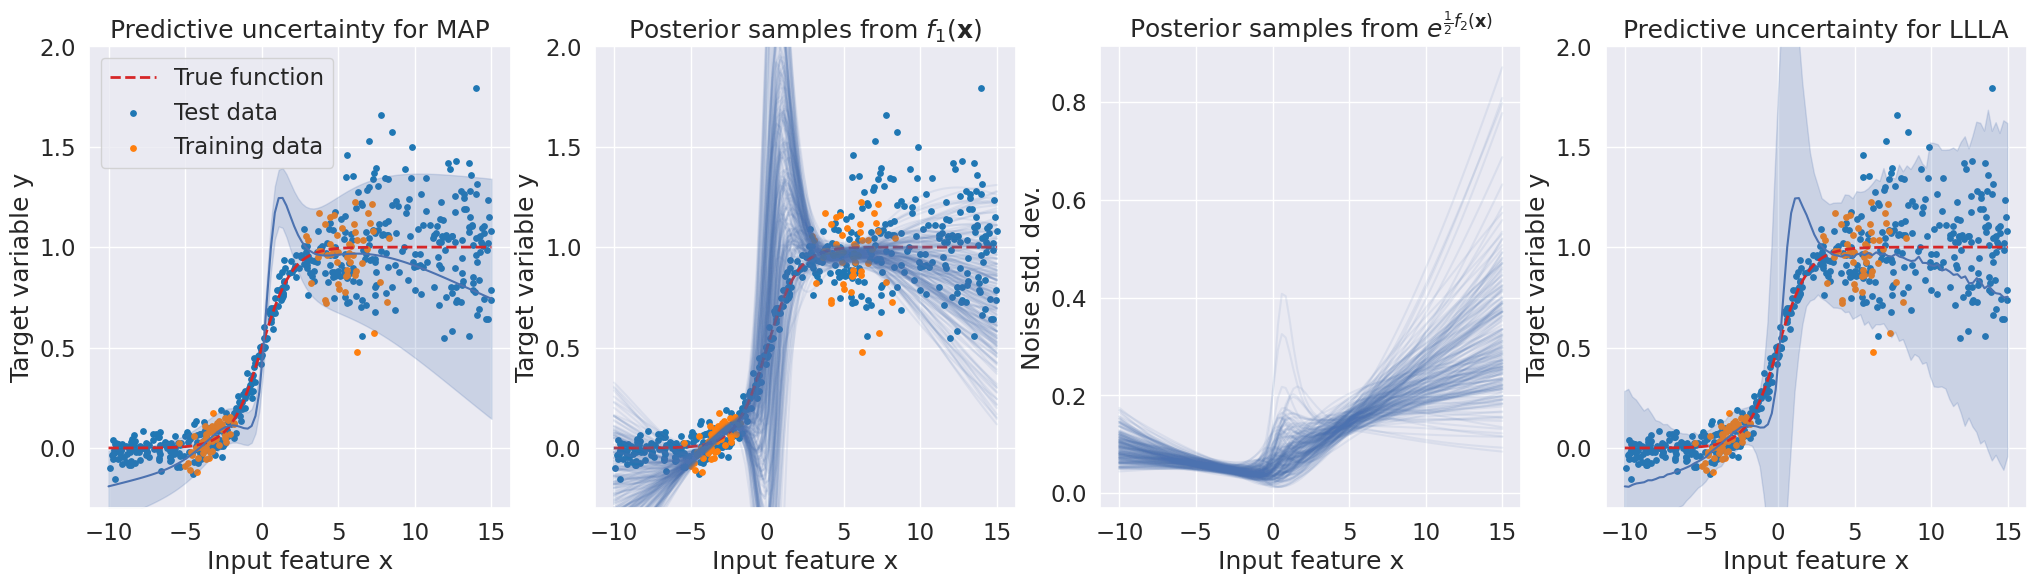

In [39]:
fig, ax = plt.subplots(1, 4, figsize=(25, 6))

# first panel: posterior predictive via plugin approximation with MAP solution
plot_data(ax[0])
ax[0].plot(Xp, mu_MAP)
ax[0].fill_between(Xp.ravel(), lower_MAP, upper_MAP, color='b', alpha=0.2)
ax[0].legend()
ax[0].set_title('Predictive uncertainty for MAP')

# second panel: posterior samples of f1(x), i.e. mean of y(x)
plot_data(ax[1])
ax[1].plot(Xp, mu_LLLA_pred[:200, :].T, 'b', alpha=0.1);
ax[1].set_title('Posterior samples from $f_1(\\mathbf{x})$')

# third panel: posterior samples of exp(0.5 f2(x)), i.e. std. dev of y(x)
ax[2].plot(Xp, jnp.sqrt(v_LLLA_pred)[:200, :].T, 'b', alpha=0.1);
ax[2].set(xlabel='Input feature x', ylabel='Noise std. dev.', title='Posterior samples from $e^{\\frac{1}{2} f_2(\\mathbf{x})}$')

# right-most: posterior predictive via LLLA
plot_data(ax[3])
plot_predictions(ax[3], Xp, mu_LLLA_pred, v_LLLA_pred)
ax[3].set_title('Predictive uncertainty for LLLA');

**Task 3.2**: Comment on the resulting fits. How does the MAP and LLLA compare? How well do the models fit in region with training data and in regions without training data? Does the uncertainty look reasonable? [**Discussion question**]


It seems very unreasonable in the middle. Its very very uncerain in the middle

**Task 3.3**:  Which of the four plots visualizes (some degree of) aleatoric uncertainty, epistemic uncertainty or a combination? [**Discussion question**]


MAP shows aleatoric uncertainty. It at least shouldnt show epistemic uncertainty as its unable to med ths. Plot 2 and 4 show a combination.

Let's now compute the training and test LPD for LLLA.

**Task 3.4**: Compute the average LPD for the training and test set for the LLLA approximation. How does the LLLA approximation compare with the MAP solution in terms of LPD?



In [40]:
npdf = lambda x, m, v: jnp.exp(log_npdf(m,x,v)) 

key = random.PRNGKey(1)
key1, key2 = random.split(key = key, num = 2)

preds_LLLA_pred = predict_LLLA(key1, X_train, model_MAP, w_MAP_flat, S_LLLA)
mus, vs = extract_mean_and_var(preds_LLLA_pred, samples=True)
log = jnp.log(jnp.mean(npdf(x = y_train.ravel(), m = mus, v = vs), axis = 0))
print(jnp.mean(log))


preds_LLLA_pred = predict_LLLA(key1, X_test, model_MAP, w_MAP_flat, S_LLLA)
mus, vs = extract_mean_and_var(preds_LLLA_pred, samples=True)
log = jnp.log(jnp.mean(npdf(x = y_test.ravel(), m = mus, v = vs), axis = 0))
print(jnp.mean(log))



# preds_LLLA_pred = predict_LLLA(key1, X_test, model_MAP, w_MAP_flat, S_LLLA)
# mus, vs = extract_mean_and_var(preds_LLLA_pred, samples=True)

# log = jnp.log(jnp.mean(npdf(x = y_test, m = mus[:,None], v = vs[:,None]), axis = 0))
# print(jnp.mean(log))

1.02842
0.29082564


## Part 4:  Deep ensembles

Finally, we will implement a deep ensemble with 10 models and compare to MAP and LLLA solutions.

Below you are given a simple template for implementing a deep ensemble:



In [41]:
class DeepEnsemble(object):

    def __init__(self):
        self.models = []
        self.num_models = 0

    def add_model(self, model):
        """ # add pretrained model"""
        self.models.append(model)
        self.num_models = len(self.models)
        
    def predict_single(self, Xp, idx_model):
        """ predict using a single model in the ensemble """
        return self.models[idx_model].predict(Xp)

    def predict(self, Xp, subset_models=None):
        # use all models in the ensemble or only a subset?
        if subset_models is None:
            list_of_models = range(self.num_models)
        else:
            list_of_models = range(subset_models)

        # compute and return predictions for each model
        return [self.predict_single(Xp, idx_model) for idx_model in list_of_models ]

    def sample_predictive_dist(self, Xp, subset_models=None, num_samples=1000, seed=123):
        """ predict using all models in the ensemble (or a subset of them) """

        key = random.PRNGKey(seed)

        # make predictions for models
        preds = self.predict(Xp, subset_models)

        # sample predictive distribution for each model
        y_samples = []
        for idx_model in range(len(preds)):
            key, subkey = random.split(key)
            mu, var = extract_mean_and_var(preds[idx_model])
            y = mu + jnp.sqrt(var)*random.normal(subkey, shape=(num_samples, len(mu)))
            y_samples.append(y)
    
        # ... and concate the results
        return jnp.concatenate(y_samples, axis=0)
    
# prepare deep ensemble
num_models = 10
ensemble_model = DeepEnsemble()
for idx_model in range(num_models):
    print(f'Training model {idx_model+1}/{num_models}')
    ensemble_model.add_model(NeuralNetwork(X_train, y_train, network_shape, log_lik_regression, alpha=alpha, step_size=1e-2, batch_size=None, num_iters=2000, seed=idx_model))


Training model 1/10
Itt = 100/2000 (5.0%), log joint = -634.79
Itt = 200/2000 (10.0%), log joint = -611.75
Itt = 300/2000 (15.0%), log joint = -608.30
Itt = 400/2000 (20.0%), log joint = -583.54
Itt = 500/2000 (25.0%), log joint = -554.56
Itt = 600/2000 (30.0%), log joint = -553.56
Itt = 700/2000 (35.0%), log joint = -554.88
Itt = 800/2000 (40.0%), log joint = -553.31
Itt = 900/2000 (45.0%), log joint = -554.31
Itt = 1000/2000 (50.0%), log joint = -551.84
Itt = 1100/2000 (55.0%), log joint = -550.81
Itt = 1200/2000 (60.0%), log joint = -567.57
Itt = 1300/2000 (65.0%), log joint = -553.14
Itt = 1400/2000 (70.0%), log joint = -550.45
Itt = 1500/2000 (75.0%), log joint = -549.57
Itt = 1600/2000 (80.0%), log joint = -549.73
Itt = 1700/2000 (85.0%), log joint = -556.82
Itt = 1800/2000 (90.0%), log joint = -560.15
Itt = 1900/2000 (95.0%), log joint = -548.07
Itt = 2000/2000 (100.0%), log joint = -547.71
Training model 2/10
Itt = 100/2000 (5.0%), log joint = -828.83
Itt = 200/2000 (10.0%), lo

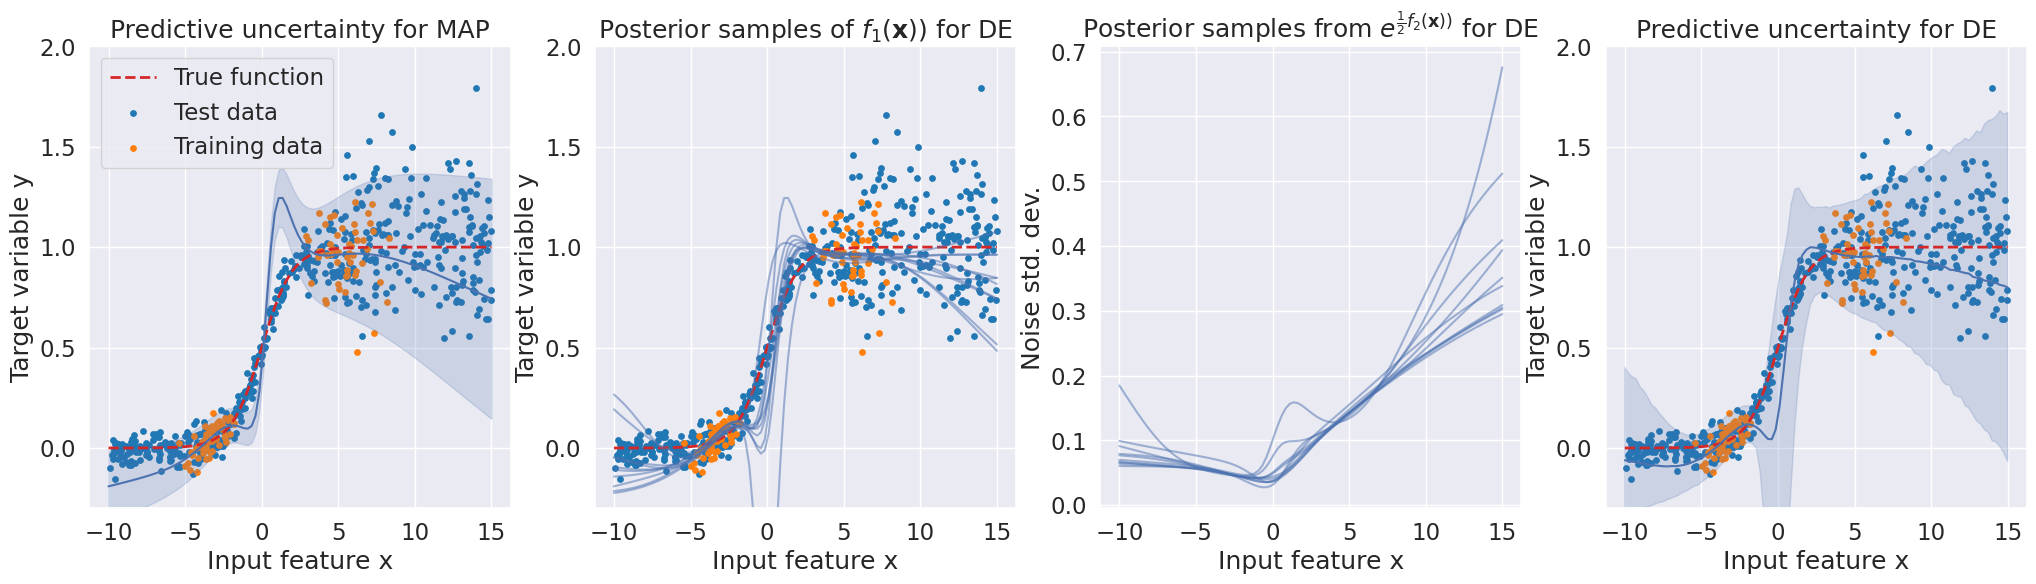

In [42]:
# compute predictions for all models in the ensemble
preds = ensemble_model.predict(Xp)

# extract mean predictions from individual models for plotting purposes
mu_ensemble, var_ensemble = extract_mean_and_var(jnp.stack(preds), True)

# generate samples from the predictive distribution
y_samples_ensemble = ensemble_model.sample_predictive_dist(Xp)

# compute mean and 95% interval
y_mean_ensemble = jnp.mean(y_samples_ensemble, axis=0)
lower_ensemble, upper_ensemble = jnp.percentile(y_samples_ensemble, jnp.array([2.5, 97.5]), axis=0)
# plot
fig, ax = plt.subplots(1, 4, figsize=(25, 6))

# first panel: posterior predictive via plugin approximation with MAP solution
plot_data(ax[0])
ax[0].set_title('Predictive uncertainty for MAP')
ax[0].plot(Xp, mu_MAP)
ax[0].fill_between(Xp.ravel(), lower_MAP, upper_MAP, color='b', alpha=0.2)
ax[0].legend()

# second panel: posterior samples of f1(x), i.e. mean of y(x)
plot_data(ax[1])
ax[1].set_title('Posterior samples of $f_1(\\mathbf{x}))$ for DE')
ax[1].plot(Xp, mu_ensemble.T, 'b', alpha=0.5);

# third panel: posterior samples of exp(0.5 f2(x)), i.e. std. dev of y(x)
ax[2].set(xlabel='Input feature x', ylabel='Noise std. dev.', title='Posterior samples from $e^{\\frac{1}{2} f_2(\\mathbf{x}))}$ for DE')
ax[2].plot(Xp, jnp.sqrt(var_ensemble).T, 'b', alpha=0.5);

# fourth panel: posterior predictive via DE
plot_data(ax[3])
ax[3].set_title('Predictive uncertainty for DE')
ax[3].plot(Xp, y_mean_ensemble)
ax[3].fill_between(Xp.ravel(), lower_ensemble, upper_ensemble, color='b', alpha=0.2);


**Task 4.1**: How does the DE approximation compare qualitatively to the MAP solution? In regions with training data? In regions without training data? [**Discussion question**]

They seem alike. Has a lot more uncertainty without data

**Task 4.2**: Compute the average log predictive density for the training and test set for the deep ensemble.

*Hints*:
- **Use equation (8) and (11)**

**Task 4.3**: How does the three methods compare in terms of LPD for the toy data? [**Discussion question**]

In [45]:
npdf = lambda x, m, v: jnp.exp(log_npdf(m,x,v)) 

key = random.PRNGKey(1)
key1, key2 = random.split(key = key, num = 2)
preds = ensemble_model.predict(X_train)
fs = []
for i in range(len(mu_ensemble)):
    mus, vs = extract_mean_and_var(preds[i])
    fs.append(log_npdf(x = y_train, m = mus[:, None], v = vs[:, None]))
fs = jnp.stack(fs)
print(jnp.mean(logsumexp(fs, axis = 0)) + jnp.log(1/len(mu_ensemble)))

preds = ensemble_model.predict(X_test)
fs = []
for i in range(len(mu_ensemble)):
    mus, vs = extract_mean_and_var(preds[i])
    fs.append(log_npdf(x = y_test, m = mus[:, None], v = vs[:, None]))
fs = jnp.stack(fs)
print(jnp.mean(logsumexp(fs, axis = 0)) + jnp.log(1/len(preds)))

1.0326173
0.24596095


# Part 5:  Modelling the Concrete dataset from the UCI repository

In this part, we will test this model with three types of inference: MAP, LLLA and DE on a real dataset. We will work with the Concrete dataset from the UCI repository.

The goal is to predict the strength of concrete based on a set of input features. See the link below for more information:

[https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength](https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength)

The dataset has $N = 1030$ observations in total and the input features are $D = 8$ dimensional.

We will use a 90/10 split for training and testing.

Let's load and prepare the data using pandas:

In [51]:
# we will load to data using pandas
import pandas as pd
df = pd.read_csv('./concrete_data.csv')

# prepare data
X = jnp.array(df.to_numpy())
y = jnp.array(X[:, -1])
X = jnp.array(X[:, :-1])

# sizes
N, D = X.shape
Ntest = int(0.1*N)

# split into training and test
key = random.PRNGKey(222)
test_idx = random.choice(key, jnp.arange(N), shape=(Ntest,), replace=False)
train_idx = jnp.setdiff1d(jnp.arange(N), test_idx)

X_train = X[train_idx, :]
X_test = X[test_idx, :]
y_train = y[train_idx][:, None]
y_test = y[test_idx][:, None]

# standardize input features
Xm, Xs = jnp.mean(X_train, 0), jnp.std(X_train, 0)
X_train = (X_train - Xm)/Xs
X_test = (X_test - Xm)/Xs

Your job is now to repeat the analysis from part 1-3 for this data set. 

Use $\alpha = \frac12$, a step size of $10^{-2}$, a batch size of $50$, and $10000$ training iterations for these experiments and the same network architecture as above.

**Task 5.1**: Fit a MAP-network to the data



In [52]:
num_inputs = 8
hidden1 = 20
hidden2 = 20
num_outputs = 2
network_shape = [num_inputs, hidden1, hidden2, num_outputs]
alpha = 0.5
# create and train network
model_MAP = NeuralNetwork(X_train, y_train, network_shape, log_lik_regression, alpha=alpha, step_size=1e-2, batch_size=50, num_iters=10000, seed=0)

Itt = 500/10000 (5.0%), log joint = -5521.36
Itt = 1000/10000 (10.0%), log joint = -5407.90
Itt = 1500/10000 (15.0%), log joint = -5315.85
Itt = 2000/10000 (20.0%), log joint = -5201.92
Itt = 2500/10000 (25.0%), log joint = -5044.16
Itt = 3000/10000 (30.0%), log joint = -4837.18
Itt = 3500/10000 (35.0%), log joint = -4649.94
Itt = 4000/10000 (40.0%), log joint = -4374.37
Itt = 4500/10000 (45.0%), log joint = -4089.93
Itt = 5000/10000 (50.0%), log joint = -3936.60
Itt = 5500/10000 (55.0%), log joint = -3866.58
Itt = 6000/10000 (60.0%), log joint = -3808.84
Itt = 6500/10000 (65.0%), log joint = -3758.70
Itt = 7000/10000 (70.0%), log joint = -3656.93
Itt = 7500/10000 (75.0%), log joint = -3579.62
Itt = 8000/10000 (80.0%), log joint = -3539.56
Itt = 8500/10000 (85.0%), log joint = -3528.18
Itt = 9000/10000 (90.0%), log joint = -3430.11
Itt = 9500/10000 (95.0%), log joint = -3383.74
Itt = 10000/10000 (100.0%), log joint = -3345.34


In [53]:
f = model_MAP.predict(X_train)
mu, v = extract_mean_and_var(f)
# log = model.log_lik_fun(f = f, y = y)
log = log_npdf(x = y_train, m = mu[:,None], v = v[:,None])
lpd_map_train = jnp.mean(log)

f = model_MAP.predict(X_test)
mu, v = extract_mean_and_var(f)
# log = model.log_lik_fun(f = f, y = y)
log = log_npdf(x = y_test, m = mu[:,None], v = v[:,None])
lpd_map_test = jnp.mean(log)

print(lpd_map_train)
print(lpd_map_test)

-2.6061091
-5.3992205


## LLLA approx

In [54]:
w_MAP_flat, S_LLLA, H, unflatten = compute_LLLA(model_MAP)


key = random.PRNGKey(1)
key1, key2 = random.split(key = key, num = 2)

preds_LLLA_pred = predict_LLLA(key1, X_train, model_MAP, w_MAP_flat, S_LLLA)
mus, vs = extract_mean_and_var(preds_LLLA_pred, samples=True)
log = jnp.log(jnp.mean(npdf(x = y_train.ravel(), m = mus, v = vs), axis = 0))

lpd_LLLA_train = jnp.mean(log)


preds_LLLA_pred = predict_LLLA(key2, X_test, model_MAP, w_MAP_flat, S_LLLA)
mus, vs = extract_mean_and_var(preds_LLLA_pred, samples=True)
log = jnp.log(jnp.mean(npdf(x = y_test.ravel(), m = mus, v = vs), axis = 0))
lpd_LLLA_test = jnp.mean(log)


In [55]:
print(lpd_LLLA_train)
print(lpd_LLLA_test)

-2.6070578
-3.9361172


In [56]:
num_models = 10
ensemble_model = DeepEnsemble()
for idx_model in range(num_models):
    print(f'Training model {idx_model+1}/{num_models}')
    ensemble_model.add_model(NeuralNetwork(X_train, y_train, network_shape, log_lik_regression, alpha=alpha, step_size=1e-2, batch_size=50, num_iters=10000, seed=idx_model))



Training model 1/10
Itt = 500/10000 (5.0%), log joint = -5521.36
Itt = 1000/10000 (10.0%), log joint = -5407.90
Itt = 1500/10000 (15.0%), log joint = -5315.85
Itt = 2000/10000 (20.0%), log joint = -5201.92
Itt = 2500/10000 (25.0%), log joint = -5044.16
Itt = 3000/10000 (30.0%), log joint = -4837.18
Itt = 3500/10000 (35.0%), log joint = -4649.94
Itt = 4000/10000 (40.0%), log joint = -4374.37
Itt = 4500/10000 (45.0%), log joint = -4089.93
Itt = 5000/10000 (50.0%), log joint = -3936.60
Itt = 5500/10000 (55.0%), log joint = -3866.58
Itt = 6000/10000 (60.0%), log joint = -3808.84
Itt = 6500/10000 (65.0%), log joint = -3758.70
Itt = 7000/10000 (70.0%), log joint = -3656.93
Itt = 7500/10000 (75.0%), log joint = -3579.62
Itt = 8000/10000 (80.0%), log joint = -3539.56
Itt = 8500/10000 (85.0%), log joint = -3528.18
Itt = 9000/10000 (90.0%), log joint = -3430.11
Itt = 9500/10000 (95.0%), log joint = -3383.74
Itt = 10000/10000 (100.0%), log joint = -3345.34
Training model 2/10
Itt = 500/10000 (5.0

In [57]:
preds = ensemble_model.predict(X_test)
fs = []
for i in range(len(preds)):
    mus, vs = extract_mean_and_var(preds[i])
    fs.append(log_npdf(x = y_test, m = mus[:, None], v = vs[:, None]))
fs = jnp.stack(fs)
lpd_ens_test = jnp.mean(logsumexp(fs, axis = 0)) + jnp.log(1/len(preds))

preds = ensemble_model.predict(X_train)
fs = []
for i in range(len(preds)):
    mus, vs = extract_mean_and_var(preds[i])
    fs.append(log_npdf(x = y_train, m = mus[:, None], v = vs[:, None]))
fs = jnp.stack(fs)
lpd_ens_train = jnp.mean(logsumexp(fs, axis = 0)) + jnp.log(1/len(preds))

print(lpd_ens_train)
print(lpd_ens_test)

-2.8200333
-3.2596524


**Task 5.2**: Compute the training and test average LPD using the MAP solution.



**Task 5.3**: Use the MAP solution to compute an LLLA approximation.



**Task 5.4**: Compute the average training and test LPD for the LLLA solution.



**Task 5.5**: Fit a deep ensemble with 10 models (it may take a little while to run, so start with a smaller number and increase the number of models when you are sure that everything is correct).



**Task 5.6**: Evaluate the training and test LPDs for the DE.



**Task 5.7**: Which of the three methods (MAP, LLLA, DE) works best for this data set? [**Discussion question**]

**Task 5.8**: Plot the performance as a function of the number of models in the ensemble. Plot the performance of the MAP solution as a horizontal line for reference. How well does the DE compare in terms of training and test performance?

*Hints*
- *First compute predictions for an ensemble with $S = 1$ model (i.e. the MAP solution), then $S = 2$, $S = 3$ etc.*
- *You only need to fit your ensemble once. After you've fitted the ensemble you can make predictions using subsets of the models using the `subset_models` argument to the `predict` function.*



In [61]:
lpds_train = []
lpds_test = []
for i in range (num_models):
    preds = ensemble_model.predict(X_train, subset_models=i+1)
    fs = []
    for i in range(len(preds)):
        mus, vs = extract_mean_and_var(preds[i])
        fs.append(log_npdf(x = y_train, m = mus[:, None], v = vs[:, None]))
    fs = jnp.stack(fs)
    lpd_ens_train = jnp.mean(logsumexp(fs, axis = 0)) + jnp.log(1/len(preds))

    preds = ensemble_model.predict(X_test, subset_models=i+1)
    fs = []
    for i in range(len(preds)):
        mus, vs = extract_mean_and_var(preds[i])
        fs.append(log_npdf(x = y_test, m = mus[:, None], v = vs[:, None]))
    fs = jnp.stack(fs)
    lpd_ens_test = jnp.mean(logsumexp(fs, axis = 0)) + jnp.log(1/len(preds))


    lpds_train.append(lpd_ens_train)
    lpds_test.append(lpd_ens_test)

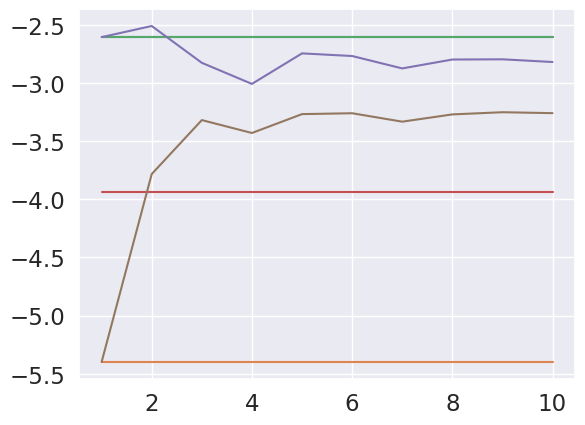

In [62]:
mods = range(1, num_models+1)

plt.plot(mods, jnp.ones(shape = (num_models,1)) *  lpd_map_train)
plt.plot(mods, jnp.ones(shape = (num_models,1)) *lpd_map_test)
plt.plot(mods, jnp.ones(shape = (num_models,1)) *  lpd_LLLA_train)
plt.plot(mods, jnp.ones(shape = (num_models,1)) *lpd_LLLA_test)
plt.plot(mods, lpds_train)
plt.plot(mods, lpds_test)
